<a href="https://colab.research.google.com/github/Durante94/Concurrent-Distributed-Programming/blob/main/ML%26DA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import spearmanr

from google.colab import drive

import time
import math

from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

Try to use TPU

In [1]:
import os

pip install h5py
pip install typing-extensions
pip install wheel
!pip install cloud-tpu-client==0.10 torch==1.12.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl

import torch_xla
import torch_xla.core.xla_model as xm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 187.4 MB 27 kB/s 
     |████████████████████████████████| 57 kB 2.8 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.11
    Uninstalling google-api-python-client-1.12.11:
      Successfully uninstalled google-api-python-client-1.12.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.326 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


**Reading Data**

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
gas_prices = 'drive/MyDrive/Colab Notebooks/datasets/NYMEX_DL_TTF1 1D.csv'
ele_prod_source = 'drive/MyDrive/Colab Notebooks/datasets/electricity-prod-source-stacked.csv'
price_path = 'drive/MyDrive/Colab Notebooks/datasets/it_electricity_prices_adj.csv'
data = pd.read_csv(price_path, index_col=0, parse_dates=True)
data = data.sort_index()
tft_data = pd.read_csv(gas_prices, sep=',', parse_dates=True)
tft_data['date'] = pd.to_datetime(tft_data['time']).apply(lambda x: x.date())
tft_data['date'] = pd.to_datetime(tft_data['date'], format='%Y-%m-%d')
tft_data.set_index('date', inplace=True)
tft_data = tft_data.drop('time', axis=1)
ele_df = pd.read_csv(ele_prod_source, index_col=[0, 2])
ita_e_df = ele_df[ele_df.Code == 'ITA']
del ele_df

# **Evaluation Data Analisys**

## **Data descriprions**

In [5]:
print(data.shape)
print(tft_data.shape)
print(ita_e_df.shape)

(92760, 16)
(1219, 6)
(57, 9)


In [6]:
print('Display Data')
print(data)
print('\r\nDescribe Data')
print(data.describe())

Display Data
                            PUN     NAT    CNOR    CSUD    NORD    SARD  \
2012-01-01 01:00:00   82.813341   76.29   83.95   83.95   83.95   83.95   
2012-01-01 02:00:00   75.767425   65.80   77.27   77.27   77.27   77.27   
2012-01-01 03:00:00   59.919853   60.00   60.00   60.00   60.00   60.00   
2012-01-01 04:00:00   59.920928   59.03   60.00   60.00   60.00   60.00   
2012-01-01 05:00:00   59.010000   59.00   59.01   59.01   59.01   59.01   
...                         ...     ...     ...     ...     ...     ...   
2022-07-31 20:00:00  436.100000  436.10  436.10  436.10  436.10  436.10   
2022-07-31 21:00:00  500.000000  500.00  500.00  500.00  500.00  500.00   
2022-07-31 22:00:00  530.000000  530.00  530.00  530.00  530.00  530.00   
2022-07-31 23:00:00  550.000000  550.00  550.00  550.00  550.00  550.00   
2022-08-01 00:00:00  530.000000  530.00  530.00  530.00  530.00  530.00   

                       SICI     SUD    AUST    COAC    CORS    FRAN    GREC  \
2012-01

## **Trend of electricity prices in the past 10 years**

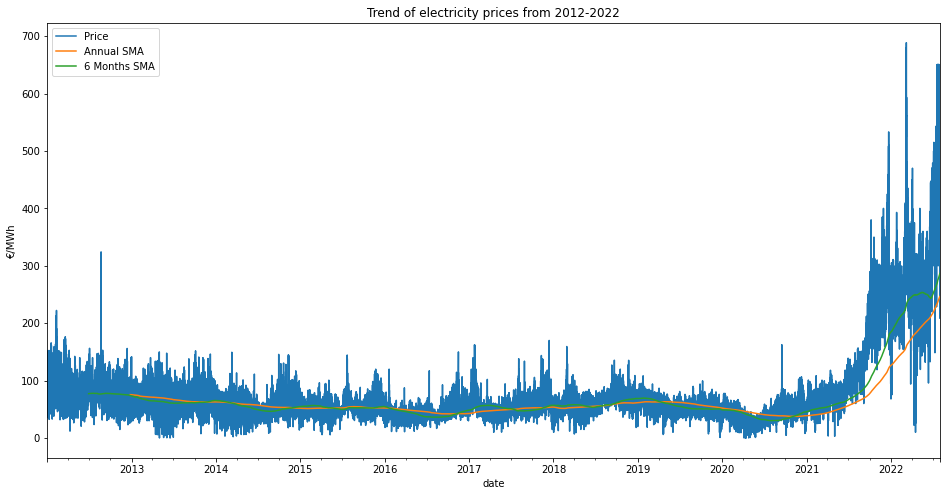

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

data.PUN.plot(ax=ax, label='Price')
data.PUN.rolling(720*12).mean().plot(ax=ax, label='Annual SMA')
data.PUN.rolling(720*6).mean().plot(ax=ax, label='6 Months SMA')

ax.set_ylabel('€/MWh')
ax.set_xlabel('date')
ax.set_title('Trend of electricity prices from 2012-2022')
ax.legend()

plt.show()

## **Standard deviation of the trend**

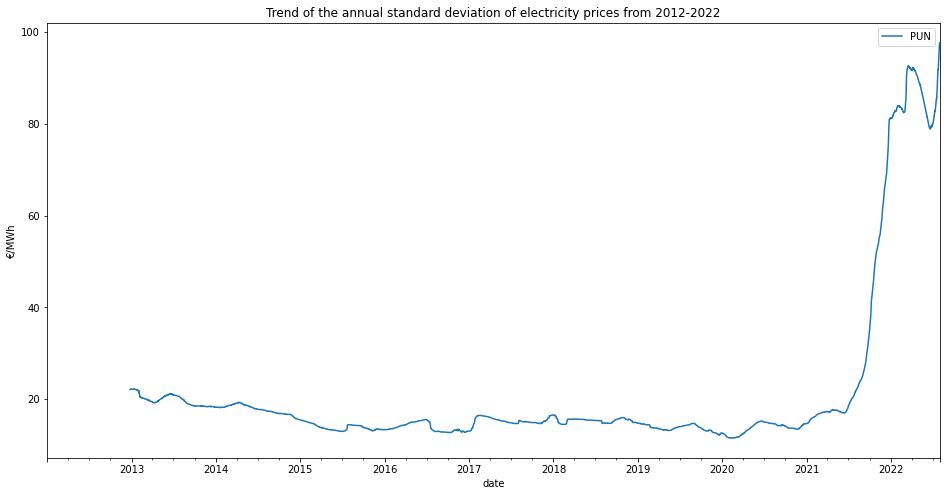

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))

data.PUN.rolling(720*12).std().plot(ax=ax)

ax.set_ylabel('€/MWh')
ax.set_xlabel('date')
ax.set_title('Trend of the annual standard deviation of electricity prices from 2012-2022')
ax.legend()

plt.show()

Looking at the annual and bi-monthly moving averages and the annual moving standard deviation we can see that those averages are pretty stable until 2021, it confirms that from 2012 to start of 2021 the prices of electricity was pretty stable.
After that period the trend become parabolic, due to Covid Pandemic and Ukranian War

## **Polynomial models**

Studying the data, it appears necessary to use two models in order to fit them properly, like the previous plots shows.

I'm going to use a linear regression model for fitting the data until 2021 and then a second order polynomial for the rest of the data

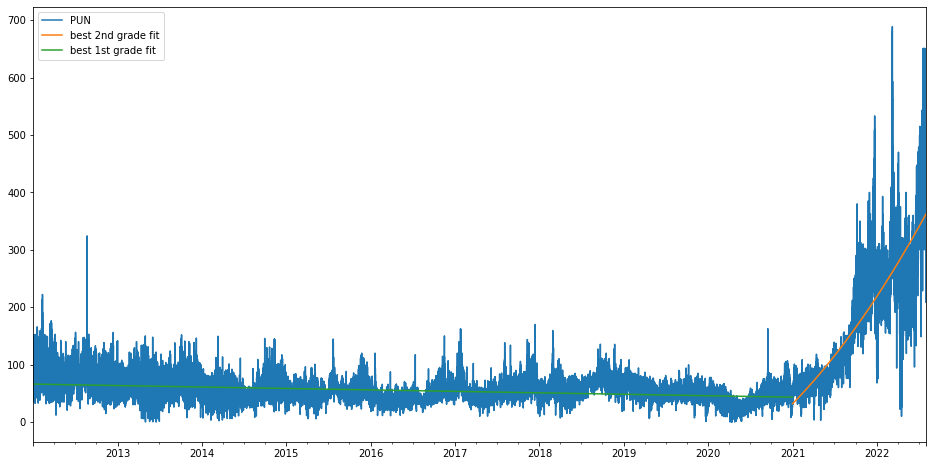



Second order degree polynomial model params
31.909115399405046 * x^0 + 0.017025571016804974 * x^1 + 4.912191394658334e-07 * x^2


First order degree polynomial model params
66.06854349510472 * x^0 + -0.000288666940582776 * x^1


In [9]:
fig, ax = plt.subplots(figsize=(16, 8))

data_2021 = data.PUN['2021':]
data.PUN.plot(ax=ax)

indexes = np.arange(1, len(data_2021) + 1)
p_2 = np.polyfit(indexes, data_2021.values, 2)
pd.DataFrame(
    {'best 2nd grade fit': np.polyval(p_2, indexes)},
    index=data_2021.index
).plot(ax=ax)

data_until_2021 = data.PUN[:'2020']

indexes = np.arange(1, len(data_until_2021) + 1)
p_1 = np.polyfit(indexes, data_until_2021.values, 1)
pd.DataFrame(
    {'best 1st grade fit': np.polyval(p_1, indexes)},
    index=data_until_2021.index
).plot(ax=ax)

plt.legend()
plt.show()

print('\r\n\r\nSecond order degree polynomial model params')
for i, c in enumerate(reversed(p_2)):
    if i == 2:
        print(f'{c} * x^{i}')
    else:
        print(f'{c} * x^{i} +', end=' ')

print('\r\n\r\nFirst order degree polynomial model params')
for i, c in enumerate(reversed(p_1)):
    if i == 1:
        print(f'{c} * x^{i}')
    else:
        print(f'{c} * x^{i} +', end=' ')

del data_until_2021
del data_2021
del p_1
del p_2

It could be useful to study the last 4 years

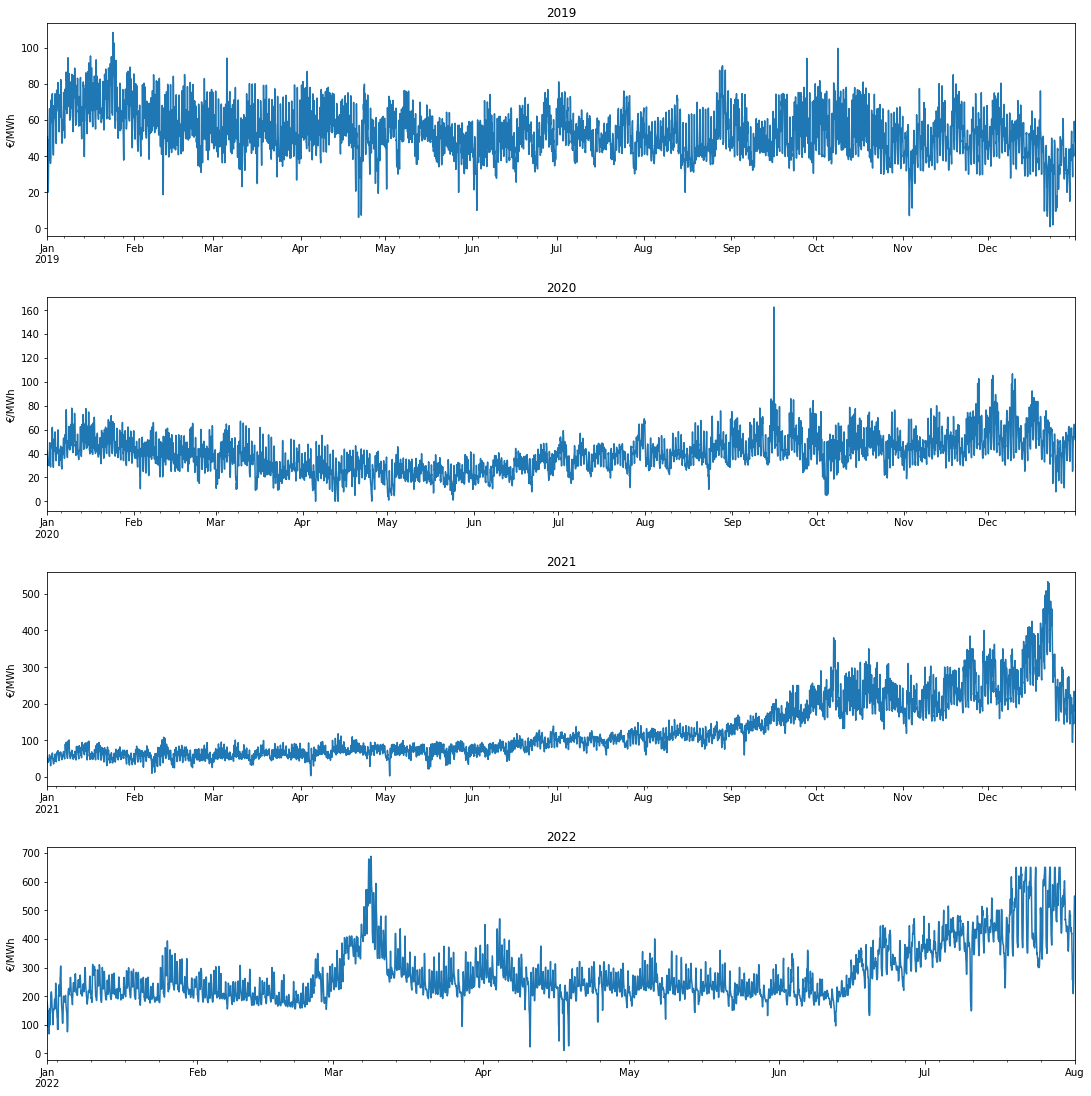

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15))
plt.tight_layout(h_pad=4)

data.PUN['2019'].plot(ax=axs[0])
axs[0].set_ylabel('€/MWh')
axs[0].set_title('2019')

data.PUN['2020'].plot(ax=axs[1])
axs[1].set_ylabel('€/MWh')
axs[1].set_title('2020')

data.PUN['2021'].plot(ax=axs[2])
axs[2].set_ylabel('€/MWh')
axs[2].set_title('2021')

data.PUN['2022'].plot(ax=axs[3])
axs[3].set_ylabel('€/MWh')
axs[3].set_title('2022')

plt.show()

## **Seasonality**

### Yearly Seasonality

I'm going to use an annual moving average, by using the library `statsmodel`, wich offers us a function `seasonal_decompose` that do the job for us.

The used sesonal model is a multiplicative one: 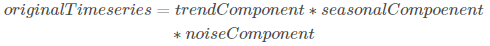

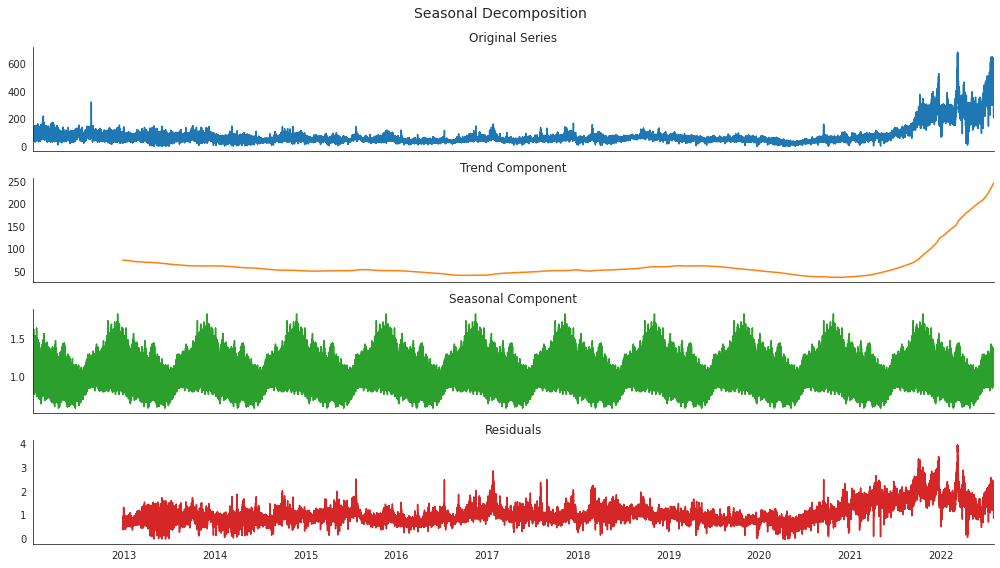

In [11]:
df_y = pd.DataFrame(data['PUN'].copy(deep=True))
df_y[df_y == 0.0] = 0.1
y_components = seasonal_decompose(df_y, model='multiplicative', period=720*12, two_sided=False)
ts = (df_y
      .assign(Trend=y_components.trend)
      .assign(Seasonality=y_components.seasonal)
      .assign(Residual=y_components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)
del df_y

Clearing the pattern considering the year 2020

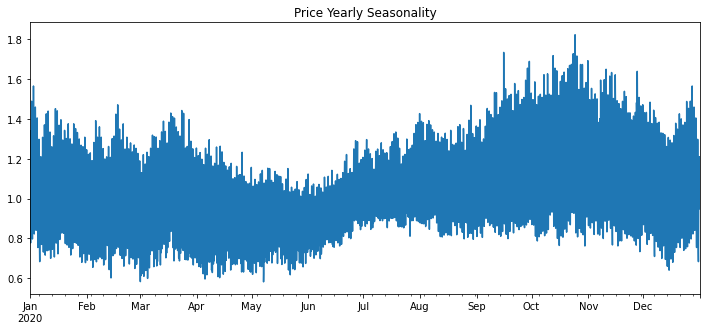

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ts.Seasonality['2020'].plot(ax=ax)
plt.title('Price Yearly Seasonality')
plt.show()

It appears that the trend tend to be higher and with higher variance around October and November, while they tend to be lower during May and July. Zooming in to these month:

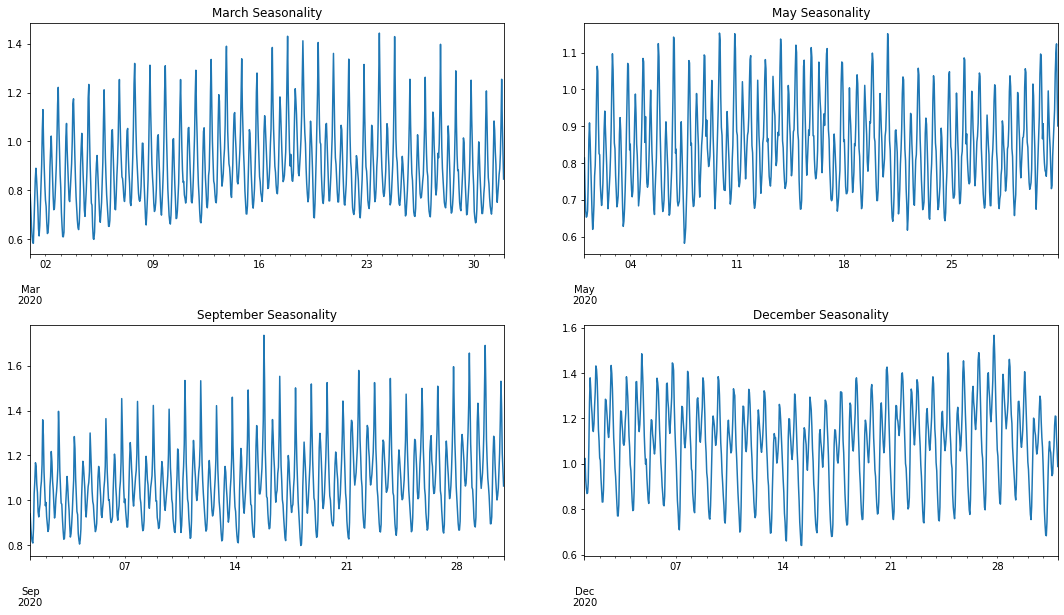

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
plt.tight_layout(h_pad=5, w_pad=5)

ts.Seasonality['2020-03'].plot(ax=axs[0, 0])
axs[0, 0].set_title('March Seasonality')

ts.Seasonality['2020-05'].plot(ax=axs[0, 1])
axs[0, 1].set_title('May Seasonality')

ts.Seasonality['2020-09'].plot(ax=axs[1, 0])
axs[1, 0].set_title('September Seasonality')

ts.Seasonality['2020-12'].plot(ax=axs[1, 1])
axs[1, 1].set_title('December Seasonality')

plt.show()

### Montly Seasonality

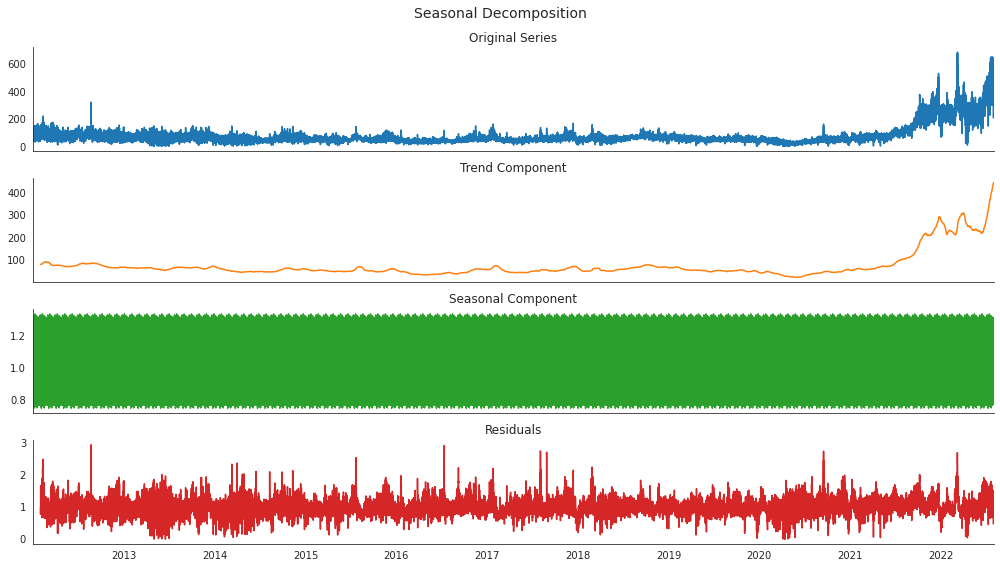

In [14]:
df_m = pd.DataFrame(data['PUN'].copy(deep=True))
df_m[df_m == 0.0] = 0.1
m_components = seasonal_decompose(df_m, model='multiplicative', period=720, two_sided=False)
m_ts = (df_m
      .assign(Trend=m_components.trend)
      .assign(Seasonality=m_components.seasonal)
      .assign(Residual=m_components.resid))
with sns.axes_style('white'):
    m_ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)

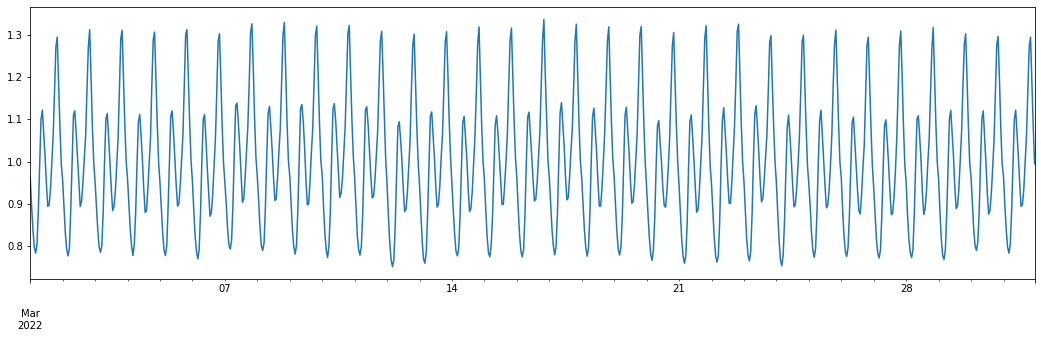

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

m_ts.Seasonality['2022-03'].plot(ax=ax)
plt.show()

### Daily Seasonality

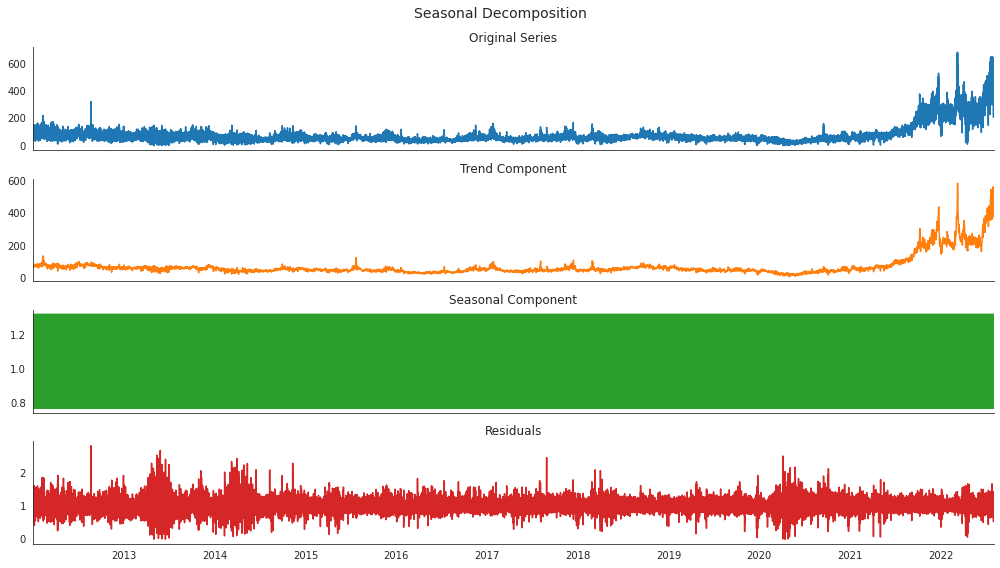

In [16]:
df_d = pd.DataFrame(data['PUN'].copy(deep=True))
df_d[df_d == 0.0] = 0.1
d_components = seasonal_decompose(df_d, model='multiplicative', period=24, two_sided=False)
d_ts = (df_m
        .assign(Trend=d_components.trend)
        .assign(Seasonality=d_components.seasonal)
        .assign(Residual=d_components.resid))
with sns.axes_style('white'):
    d_ts.plot(subplots=True, figsize=(14, 8),
              title=['Original Series', 'Trend Component', 'Seasonal Component', 'Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91)
del df_d
del df_m
del d_components

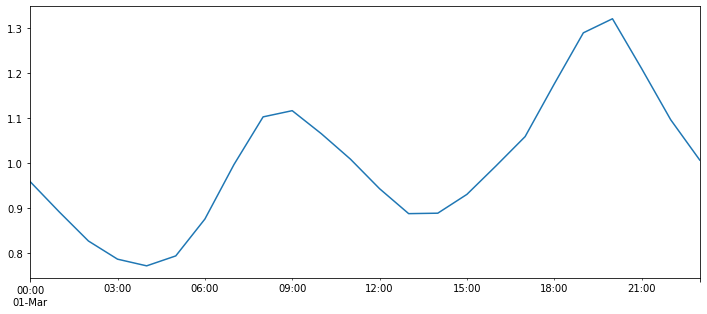

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

d_ts.Seasonality['2022-03-01'].plot(ax=ax)
plt.show()
del d_ts

## Correlation with Gas prices

I'm going to study the gas proces because is the main electricity source in Italy

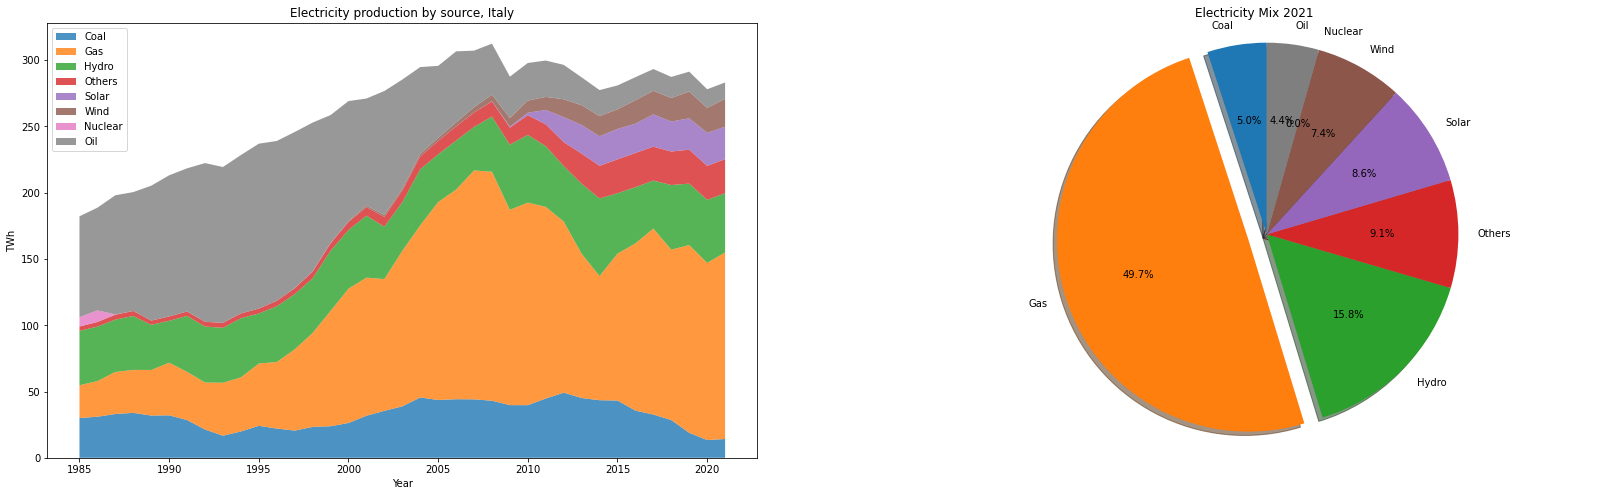

In [18]:
ita_e_df = ita_e_df.dropna()
ita_e_df = ita_e_df.sort_index()
ita_e_df = ita_e_df.drop('Code', axis=1)
year = [int(y) for _, y in ita_e_df.index.values]
electricity_by_source = {
    'Coal': ita_e_df['Electricity from coal (TWh)'].values,
    'Gas': ita_e_df['Electricity from gas (TWh)'].values,
    'Hydro': ita_e_df['Electricity from hydro (TWh)'].values,
    'Others': ita_e_df['Electricity from other renewables including bioenergy (TWh)'].values,
    'Solar': ita_e_df['Electricity from solar (TWh)'].values,
    'Wind': ita_e_df['Electricity from wind (TWh)'].values,
    'Nuclear': ita_e_df['Electricity from nuclear (TWh)'].values,
    'Oil': ita_e_df['Electricity from oil (TWh)'].values
}

fig, ax = plt.subplots(1, 2, figsize=(28, 8))
ax[0].stackplot(year, electricity_by_source.values(), labels=electricity_by_source.keys(), alpha=0.8)
ax[0].legend(loc='upper left')
ax[0].set_title('Electricity production by source, Italy')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('TWh')

labels = electricity_by_source.keys()
sizes = [v[-1] for v in electricity_by_source.values()]
explode = (0, 0.1, 0, 0, 0, 0, 0, 0)

ax[1].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].axis('equal')
ax[1].set_title('Electricity Mix 2021')

plt.show()

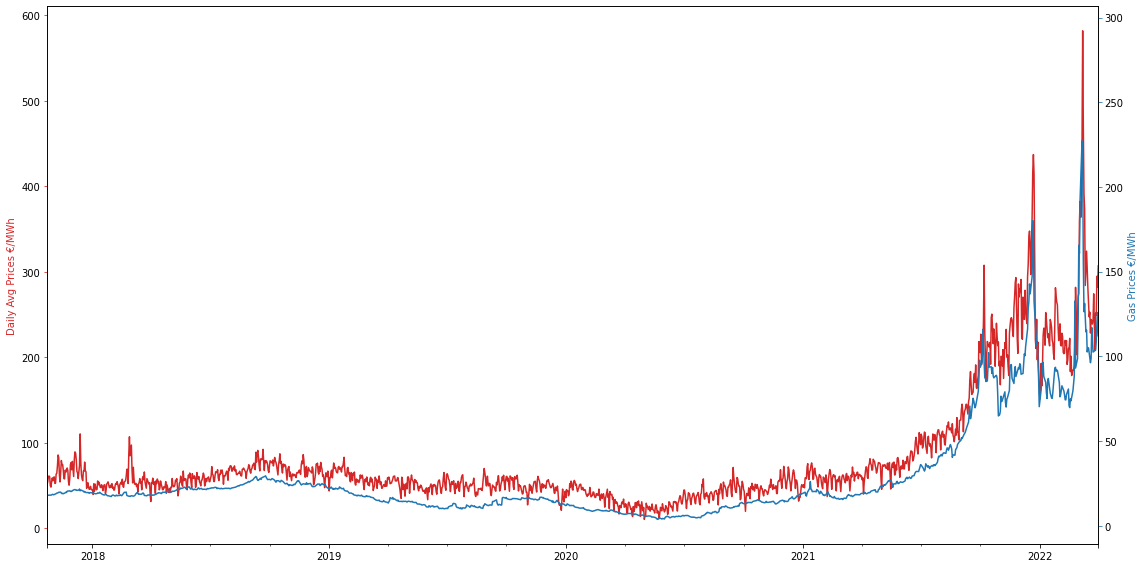

In [19]:
daily_prices = data.PUN.resample('D').mean()
fig, ax = plt.subplots(figsize=(16, 8))

color = 'tab:red'
daily_prices.plot(ax=ax, color=color)
ax.set_ylabel('Daily Avg Prices €/MWh', color=color)
ax.tick_params(axis='y', color=color)

ax2 = ax.twinx()
color = 'tab:blue'
tft_data.close.plot(ax=ax2, color=color)
ax2.set_ylabel('Gas Prices €/MWh', color=color)
ax2.tick_params(axis='y', color=color)

plt.xlim(pd.Timestamp('2017-10-23'), pd.Timestamp('2022-03-31'))

fig.tight_layout()
plt.show()

As you can see from above, the Italian electricity price trend is almost the same as the price trend of gas listed on the Dutch stock exchange.

In [20]:
print(np.corrcoef(daily_prices[tft_data[:'2022-03-31'].index].values, tft_data[:'2022-03-31'].close.values)[0, 1])

spearmanr(daily_prices[tft_data[:'2022-03-31'].index].values, tft_data[:'2022-03-31'].close.values, axis=1, nan_policy='omit')
del daily_prices

0.9755743369944587


This high correlation is also confirmed numerically by the Pearson correlation coefficient and the Spearmanr correlation coefficient. Both of them are close to 1, that means that there is high positive linear correlation between the two.

# **Italian Electricity Price forecasting**

## **Data reading and parameters preparation**

In [21]:
torch.manual_seed(0)
np.random.seed(0)
save_model_path = 'drive/MyDrive/Colab Notebooks/datasets/tft_price_it.chkpt'

## **Preprocessing**

* Standardize the data: we know that neural network like standardized data
  * the target of the model is PUN (which stand for 'Prezzo Unico Nazionale', Single National Price in english), I'm going to keep a StandardScaler for the input data and one different StandardScaler for the output data
* Add categorical time varying features such as day, month, hour
* Add static features (if it's working day or not, ...)

In [22]:
cols_to_keep = ['PUN', 'NAT', 'CNOR', 'CSUD', 'NORD', 'SARD', 'SICI', 'SUD']
price_df = data[cols_to_keep].copy(deep=True);
target_df = pd.DataFrame(price_df.PUN)
input_sc = StandardScaler()
output_sc = StandardScaler()
price_df.loc[:, cols_to_keep] = input_sc.fit_transform(price_df[cols_to_keep])
target_df.PUN = output_sc.fit_transform(target_df)
price_df = price_df.assign(hour=0)
price_df = price_df.assign(month=0)
price_df = price_df.assign(weekday=0)

price_df.loc[:, 'month'] = price_df.index.month
price_df.loc[:, 'hour'] = price_df.index.hour
price_df.loc[:, 'weekday'] = price_df.index.weekday

price_df = price_df.assign(working_day=1)
price_df.loc[price_df[price_df.weekday == 6].index, 'working_day'] = 0
price_df.loc[price_df[price_df.weekday == 5].index, 'working_day'] = 0
price_df.month = price_df.month - 1
print('Price DataFrame')
print(price_df)
print('\r\nTarget DataFrame')
print(target_df)

Price DataFrame
                          PUN       NAT      CNOR      CSUD      NORD  \
2012-01-01 01:00:00  0.140822  0.057303  0.163274  0.185943  0.162104   
2012-01-01 02:00:00  0.033463 -0.101577  0.063603  0.082469  0.062346   
2012-01-01 03:00:00 -0.208007 -0.189423 -0.194078 -0.185046 -0.195562   
2012-01-01 04:00:00 -0.207991 -0.204114 -0.194078 -0.185046 -0.195562   
2012-01-01 05:00:00 -0.221870 -0.204569 -0.208850 -0.200382 -0.210347   
...                       ...       ...       ...       ...       ...   
2022-07-31 20:00:00  5.523868  5.506920  5.417624  5.640809  5.421071   
2022-07-31 21:00:00  6.497515  6.474738  6.371061  6.630631  6.375346   
2022-07-31 22:00:00  6.954627  6.929112  6.818684  7.095337  6.823362   
2022-07-31 23:00:00  7.259368  7.232028  7.117099  7.405140  7.122040   
2022-08-01 00:00:00  6.954627  6.929112  6.818684  7.095337  6.823362   

                         SARD      SICI       SUD  hour  month  weekday  \
2012-01-01 01:00:00  0.165873 -0

In [23]:
class TSDataset(Dataset):
    def __init__(self, static_cols, input_cols,
                 input_timesteps, output_timesteps,
                 encoder_len, data: pd.DataFrame, target: pd.DataFrame):
        assert len(data) == len(target)
        
        self.input_timesteps = input_timesteps
        self.output_timesteps = output_timesteps
        self.input_size = len(input_cols)
        self.num_static = len(static_cols)
        self.len = len(data)
        self.data = data
        self.target = target
        self.static_cols = static_cols
        self.input_cols = input_cols
        self.encoder_len = encoder_len
        
    def __getitem__(self, idx):

      if isinstance(idx, slice):
        X_static = Variable(torch.stack(
            [torch.Tensor(self.data[self.static_cols].iloc[i:i + self.input_timesteps].values) for i in range(*idx.indices(len(self.data)))]
        ))
        X = Variable(torch.stack(
            [torch.Tensor(self.data[self.input_cols].iloc[i:i + self.input_timesteps].values) for i in range(*idx.indices(len(self.data)))]
        ))
        y = Variable(torch.stack(
            [torch.Tensor(self.target[['PUN']].iloc[i + self.encoder_len:i + self.encoder_len + self.output_timesteps].values) for i in range(*idx.indices(len(self.data)))]
        ))
        return X_static, X, y
      else:
        end_idx = idx + self.input_timesteps
        start_out_idx = idx + self.encoder_len
        out_end_idx = start_out_idx + self.output_timesteps
        X_static = Variable(torch.Tensor(self.data[self.static_cols].iloc[idx:end_idx].values))
        X = Variable(torch.Tensor(self.data[self.input_cols].iloc[idx:end_idx].values))
        y = Variable(torch.Tensor(self.target[['PUN']].iloc[start_out_idx:out_end_idx].values))

        return X_static, X, y

    def get_dates(self, idx):

        if isinstance(idx, slice):
            in_dates = np.stack(
                [self.data.iloc[i:i + self.input_timesteps].index.values for i in range(*idx.indices(len(self.data)))],
                axis=0
            )
            out_dates = np.stack(
                [self.target.iloc[i + self.encoder_len:i + self.encoder_len + self.output_timesteps].index.values for i in range(*idx.indices(len(self.data)))],
                axis=0
            )
            return in_dates, out_dates
        else:
            end_idx = idx + self.input_timesteps
            start_out_idx = idx + self.encoder_len
            out_end_idx = start_out_idx + self.output_timesteps
            in_dates = self.data.iloc[idx:end_idx].index_values
            out_dates = self.target.iloc[start_out_idx:out_end_idx].index_values
            return in_dates, out_dates

    def __len__(self):
        return self.len - self.input_timesteps

In [24]:
static_cols = ['working_day']
cat_cols = ['month', 'hour', 'weekday']
input_cols = cols_to_keep + cat_cols
output_col = 'PUN'
input_timesteps = 192
encoder_len = 168
output_timesteps = 24

## **Train, Test and Validation datasets**

For the train set we are going to use the first 80% of the data, the val is going to be the 10% of the data after the train set and the test set is going to be composed by the rest of the data.

I decided to use the latter part of the data as a training set as there has never been such a sharp spike in electricity prices in the last 10 years, and as a result, the model would not perform decently

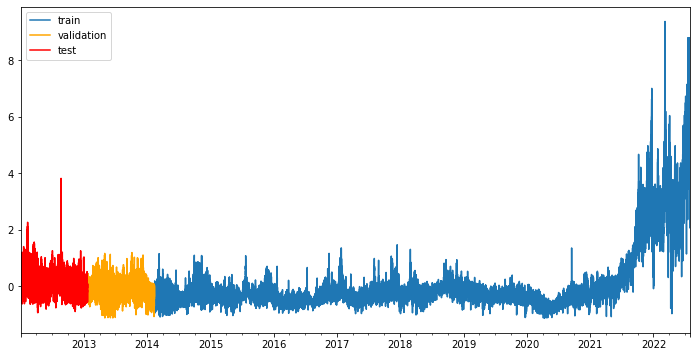

In [25]:
last_test_idx = int(np.round(len(price_df)) * 0.1)
last_val_idx = int(np.round(len(price_df)) * 0.2)
fig, ax = plt.subplots(figsize=(12, 6))

price_df.PUN[last_val_idx:].plot(ax=ax, label='train')
price_df.PUN[last_test_idx:last_val_idx].plot(ax=ax, color='orange', label='validation')
price_df.PUN[0:last_test_idx].plot(ax=ax, color='red', label='test')

plt.legend()
plt.show()

trainset = TSDataset(data=price_df[last_val_idx:], target=target_df[last_val_idx:],
                     static_cols=static_cols, input_cols=input_cols,
                    input_timesteps=input_timesteps, output_timesteps=output_timesteps, 
                     encoder_len=encoder_len)
valset = TSDataset(data=price_df[last_test_idx:last_val_idx], target=target_df[last_test_idx:last_val_idx],
                   static_cols=static_cols, input_cols=input_cols,
                   input_timesteps=input_timesteps, output_timesteps=output_timesteps,
                   encoder_len=encoder_len)
testset = TSDataset(data=price_df[0:last_test_idx], target=target_df[0:last_test_idx], static_cols=static_cols,
                    input_cols=input_cols, input_timesteps=input_timesteps,
                    output_timesteps=output_timesteps, encoder_len=encoder_len)

## **Device selection**

Checking my os configuration in order to take the best hardware accelator possible

In [26]:
device = None
tpu_available = os.getenv('COLAB_TPU_ADDR')
if tpu_available is None:
  print('Make sure to select TPU from Edit > Notebook settings > Hardware accelerator')
else:
  device = xm.xla_device(n=1, devkind='TPU')
if device is None:
  CUDA = torch.cuda.is_available()
  device = 'cuda:0' if CUDA else 'cpu'

print(device)

xla:1


## **Model - Temporal Fusion Transformer**
The model that I've decided to use is the Temporal Fusion Transformer. Apart from leverage the transformer architecture and the attention mechanism, this model is not going to output a single number but an interval via quantile forecast to determine the range of likely target values at each prediction horizion

Model [paper](https://arxiv.org/pdf/1912.09363.pdf)

In [27]:
# Code took from: https://github.com/mattsherar/Temporal_Fusion_Transform/blob/master/tft_model.py

class QuantileLoss(nn.Module):

    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)

        losses = []

        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, :, i].unsqueeze(2)
            losses.append(
                torch.max(
                   (q-1) * errors, 
                   q * errors
            ).unsqueeze(1))
        loss = torch.mean(
            torch.sum(torch.cat(losses, dim=1), dim=1))
        
        return loss

class TimeDistributed(nn.Module):
    ## Takes any module and stacks the time dimension with the batch dimenison of inputs before apply the module
    ## From: https://discuss.pytorch.org/t/any-pytorch-function-can-work-as-keras-timedistributed/1346/4

    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

class GLU(nn.Module):
    #Gated Linear Unit

    def __init__(self, input_size):
        super(GLU, self).__init__()
        
        self.fc1 = nn.Linear(input_size,input_size)
        self.fc2 = nn.Linear(input_size, input_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        sig = self.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return torch.mul(sig, x)


class GatedResidualNetwork(nn.Module):

    def __init__(self, input_size,hidden_state_size, output_size, dropout, hidden_context_size=None, batch_first=False):
        super(GatedResidualNetwork, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_context_size = hidden_context_size
        self.hidden_state_size=hidden_state_size
        self.dropout = dropout
        
        if self.input_size!=self.output_size:
            self.skip_layer = TimeDistributed(nn.Linear(self.input_size, self.output_size))

        self.fc1 = TimeDistributed(nn.Linear(self.input_size, self.hidden_state_size), batch_first=batch_first)
        self.elu1 = nn.ELU()
        
        if self.hidden_context_size is not None:
            self.context = TimeDistributed(nn.Linear(self.hidden_context_size, self.hidden_state_size),batch_first=batch_first)
            
        self.fc2 = TimeDistributed(nn.Linear(self.hidden_state_size,  self.output_size), batch_first=batch_first)
        self.elu2 = nn.ELU()
        
        self.dropout = nn.Dropout(self.dropout)
        self.bn = TimeDistributed(nn.BatchNorm1d(self.output_size),batch_first=batch_first)
        self.gate = TimeDistributed(GLU(self.output_size), batch_first=batch_first)

    def forward(self, x, context=None):

        if self.input_size!=self.output_size:
            residual = self.skip_layer(x)
        else:
            residual = x
        
        x = self.fc1(x)
        if context is not None:
            context = self.context(context)
            x = x+context
        x = self.elu1(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.gate(x)
        x = x+residual
        x = self.bn(x)
        
        return x

class PositionalEncoder(torch.nn.Module):

    def __init__(self, d_model, max_seq_len=160):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                    math.sin(pos / (10000 ** ((2 * i) / d_model)))
                pe[pos, i + 1] = \
                    math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        with torch.no_grad():
            x = x * math.sqrt(self.d_model)
            seq_len = x.size(0)
            pe = self.pe[:, :seq_len].view(seq_len,1,self.d_model)
            x = x + pe
            return x

class VariableSelectionNetwork(nn.Module):

    def __init__(self, input_size, num_inputs, hidden_size, dropout, context=None):
        super(VariableSelectionNetwork, self).__init__()

        self.hidden_size = hidden_size
        self.input_size =input_size
        self.num_inputs = num_inputs
        self.dropout = dropout
        self.context=context

        if self.context is not None:
            self.flattened_grn = GatedResidualNetwork(self.num_inputs*self.input_size, self.hidden_size, self.num_inputs, self.dropout, self.context)
        else:
            self.flattened_grn = GatedResidualNetwork(self.num_inputs*self.input_size, self.hidden_size, self.num_inputs, self.dropout)


        self.single_variable_grns = nn.ModuleList()
        for i in range(self.num_inputs):
            self.single_variable_grns.append(GatedResidualNetwork(self.input_size, self.hidden_size, self.hidden_size, self.dropout))

        self.softmax = nn.Softmax(dim=2)

    def forward(self, embedding, context=None):
        if context is not None:
            sparse_weights = self.flattened_grn(embedding, context)
        else:
            sparse_weights = self.flattened_grn(embedding)

        sparse_weights = self.softmax(sparse_weights).unsqueeze(2)

        var_outputs = []
        for i in range(self.num_inputs):
            ##select slice of embedding belonging to a single input
            var_outputs.append(self.single_variable_grns[i](embedding[:,:, (i*self.input_size) : (i+1)*self.input_size]))

        var_outputs = torch.stack(var_outputs, axis=-1)

        outputs = var_outputs*sparse_weights
        
        outputs = outputs.sum(axis=-1)

        return outputs, sparse_weights



class TFT(nn.Module):

    def __init__(self, config):
        super(TFT, self).__init__()
        self.device = config['device']
        self.batch_size = config['batch_size']
        self.static_variables = config['static_variables']
        self.encode_length = config['encode_length']
        self.time_varying_categoical_variables =  config['time_varying_categoical_variables']
        self.time_varying_real_variables_encoder =  config['time_varying_real_variables_encoder']
        self.time_varying_real_variables_decoder =  config['time_varying_real_variables_decoder']
        self.num_input_series_to_mask = config['num_masked_series']
        self.hidden_size = config['lstm_hidden_dimension']
        self.lstm_layers = config['lstm_layers']
        self.dropout = config['dropout']
        self.embedding_dim = config['embedding_dim']
        self.attn_heads = config['attn_heads']
        self.num_quantiles = config['num_quantiles']
        self.valid_quantiles = config['vailid_quantiles']
        self.seq_length = config['seq_length']
        
        self.static_embedding_layers = nn.ModuleList()
        for i in range(self.static_variables):
            emb = nn.Embedding(config['static_embedding_vocab_sizes'][i], config['embedding_dim']).to(self.device)
            self.static_embedding_layers.append(emb)
        
        self.time_varying_embedding_layers = nn.ModuleList()
        for i in range(self.time_varying_categoical_variables):
            emb = TimeDistributed(nn.Embedding(config['time_varying_embedding_vocab_sizes'][i], config['embedding_dim']), batch_first=True).to(self.device)
            self.time_varying_embedding_layers.append(emb)
            
        self.time_varying_linear_layers = nn.ModuleList()
        for i in range(self.time_varying_real_variables_encoder):
            emb = TimeDistributed(nn.Linear(1, config['embedding_dim']), batch_first=True).to(self.device)
            self.time_varying_linear_layers.append(emb)

        self.encoder_variable_selection = VariableSelectionNetwork(config['embedding_dim'],
                                (config['time_varying_real_variables_encoder'] +  config['time_varying_categoical_variables']),
                                self.hidden_size,
                                self.dropout,
                                config['embedding_dim']*config['static_variables'])

        self.decoder_variable_selection = VariableSelectionNetwork(config['embedding_dim'],
                                (config['time_varying_real_variables_decoder'] +  config['time_varying_categoical_variables']),
                                self.hidden_size,
                                self.dropout,
                                config['embedding_dim']*config['static_variables'])

        self.lstm_encoder_input_size = config['embedding_dim']*(config['time_varying_real_variables_encoder'] +  
                                                        config['time_varying_categoical_variables'] +
                                                        config['static_variables'])
        
        self.lstm_decoder_input_size = config['embedding_dim']*(config['time_varying_real_variables_decoder'] +  
                                                        config['time_varying_categoical_variables'] +
                                                        config['static_variables'])

        self.lstm_encoder = nn.LSTM(input_size=self.hidden_size, 
                            hidden_size=self.hidden_size,
                           num_layers=self.lstm_layers)
        
        self.lstm_decoder = nn.LSTM(input_size=self.hidden_size,
                                   hidden_size=self.hidden_size,
                                   num_layers=self.lstm_layers)

        self.post_lstm_gate = TimeDistributed(GLU(self.hidden_size))
        self.post_lstm_norm = TimeDistributed(nn.BatchNorm1d(self.hidden_size))

        self.static_enrichment = GatedResidualNetwork(self.hidden_size,self.hidden_size, self.hidden_size, self.dropout, config['embedding_dim']*self.static_variables)
        
        self.position_encoding = PositionalEncoder(self.hidden_size, self.seq_length)

        self.multihead_attn = nn.MultiheadAttention(self.hidden_size, self.attn_heads)
        self.post_attn_gate = TimeDistributed(GLU(self.hidden_size))

        self.post_attn_norm = TimeDistributed(nn.BatchNorm1d(self.hidden_size, self.hidden_size))
        self.pos_wise_ff = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout)

        self.pre_output_norm = TimeDistributed(nn.BatchNorm1d(self.hidden_size, self.hidden_size))
        self.pre_output_gate = TimeDistributed(GLU(self.hidden_size))

        self.output_layer = TimeDistributed(nn.Linear(self.hidden_size, self.num_quantiles), batch_first=True)
        
    def init_hidden(self):
        return torch.zeros(self.lstm_layers, self.batch_size, self.hidden_size, device=self.device)
        
    def apply_embedding(self, x, static_embedding, apply_masking):
        ###x should have dimensions (batch_size, timesteps, input_size)
        ## Apply masking is used to mask variables that should not be accessed after the encoding steps
        #Time-varying real embeddings 
        if apply_masking:
            time_varying_real_vectors = []
            for i in range(self.time_varying_real_variables_decoder):
                emb = self.time_varying_linear_layers[i+self.num_input_series_to_mask](x[:,:,i+self.num_input_series_to_mask].view(x.size(0), -1, 1))
                time_varying_real_vectors.append(emb)
            time_varying_real_embedding = torch.cat(time_varying_real_vectors, dim=2)

        else: 
            time_varying_real_vectors = []
            for i in range(self.time_varying_real_variables_encoder):
                emb = self.time_varying_linear_layers[i](x[:,:,i].view(x.size(0), -1, 1))
                time_varying_real_vectors.append(emb)
            time_varying_real_embedding = torch.cat(time_varying_real_vectors, dim=2)

         ##Time-varying categorical embeddings (ie hour)
        time_varying_categoical_vectors = []
        for i in range(self.time_varying_categoical_variables):
            emb = self.time_varying_embedding_layers[i](x[:, :, self.time_varying_real_variables_encoder+i].view(x.size(0), -1, 1).long())
            time_varying_categoical_vectors.append(emb)
        time_varying_categoical_embedding = torch.cat(time_varying_categoical_vectors, dim=2)  

        ##repeat static_embedding for all timesteps
        static_embedding = torch.cat(time_varying_categoical_embedding.size(1)*[static_embedding])
        static_embedding = static_embedding.view(time_varying_categoical_embedding.size(0),time_varying_categoical_embedding.size(1),-1 )
        
        ##concatenate all embeddings
        embeddings = torch.cat([static_embedding, time_varying_categoical_embedding, time_varying_real_embedding], dim=2)
        
        return embeddings.view(-1, x.size(0), embeddings.size(2))
    
    def encode(self, x, hidden=None):
    
        if hidden is None:
            hidden = self.init_hidden()
            
        output, (hidden, cell) = self.lstm_encoder(x, (hidden, hidden))
        
        return output, hidden
        
    def decode(self, x, hidden=None):
        
        if hidden is None:
            hidden = self.init_hidden()
            
        output, (hidden, cell) = self.lstm_decoder(x, (hidden,hidden))
        
        return output, hidden

    def forward(self, x, static):

        ##inputs should be in this order
        # static
        # time_varying_categorical
        # time_varying_real

        embedding_vectors = []
        for i in range(self.static_variables):
            # only need static variable from the first timestep
            emb = self.static_embedding_layers[i](static[:, 0, i].long().to(self.device))
            embedding_vectors.append(emb)

        ##Embedding and variable selection
        static_embedding = torch.cat(embedding_vectors, dim=1)
        embeddings_encoder = self.apply_embedding(x[:, :self.encode_length, :].float().to(self.device),
                                                  static_embedding, apply_masking=False)
        embeddings_decoder = self.apply_embedding(x[:, self.encode_length:, :].float().to(self.device),
                                                  static_embedding, apply_masking=True)
        embeddings_encoder, encoder_sparse_weights = self.encoder_variable_selection(
            embeddings_encoder[:, :, :-(self.embedding_dim * self.static_variables)],
            embeddings_encoder[:, :, -(self.embedding_dim * self.static_variables):])
        embeddings_decoder, decoder_sparse_weights = self.decoder_variable_selection(
            embeddings_decoder[:, :, :-(self.embedding_dim * self.static_variables)],
            embeddings_decoder[:, :, -(self.embedding_dim * self.static_variables):])

        pe = self.position_encoding(torch.zeros(self.seq_length, 1, embeddings_encoder.size(2)).to(self.device)).to(
            self.device)

        embeddings_encoder = embeddings_encoder + pe[:self.encode_length, :, :]
        embeddings_decoder = embeddings_decoder + pe[self.encode_length:, :, :]

        ##LSTM
        lstm_input = torch.cat([embeddings_encoder, embeddings_decoder], dim=0)
        encoder_output, hidden = self.encode(embeddings_encoder)
        decoder_output, _ = self.decode(embeddings_decoder, hidden)
        lstm_output = torch.cat([encoder_output, decoder_output], dim=0)

        ##skip connection over lstm
        lstm_output = self.post_lstm_gate(lstm_output + lstm_input)
        lstm_output = self.post_lstm_norm(lstm_output)

        ##static enrichment
        static_embedding = torch.cat(lstm_output.size(0) * [static_embedding]).view(lstm_output.size(0),
                                                                                    lstm_output.size(1), -1)
        attn_input = self.static_enrichment(lstm_output, static_embedding)

        ##Attention
        attn_output, attn_output_weights = self.multihead_attn(attn_input[self.encode_length:, :, :],
                                                               attn_input[:self.encode_length, :, :],
                                                               attn_input[:self.encode_length, :, :])

        ##skip connection over attention
        attn_output = self.post_attn_gate(attn_output) + attn_input[self.encode_length:, :, :]
        attn_output = self.post_attn_norm(attn_output)

        output = self.pos_wise_ff(attn_output)  # [self.encode_length:,:,:])

        ##skip connection over Decoder
        output = self.pre_output_gate(output) + lstm_output[self.encode_length:, :, :]

        # Final output layers
        output = self.pre_output_norm(output)
        output = self.output_layer(output.view(self.batch_size, -1, self.hidden_size))

        return output, encoder_output, decoder_output, attn_output, attn_output_weights, encoder_sparse_weights, decoder_sparse_weights

Before train the network, I initialized in a proper manner the neural network weights. Here I've decided to use the Glorot Uniform initialization function.

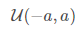

where 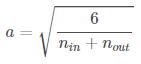

In [28]:
@torch.no_grad()
def init_xuniform(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)
    
static_cols = ['working_day']
categorical_cols = ['hour', 'month', 'weekday']
real_cols = cols_to_keep
config = {
    'static_variables': len(static_cols),
    'time_varying_categoical_variables': len(categorical_cols),
    'time_varying_real_variables_encoder': len(real_cols),
    'time_varying_real_variables_decoder': len(real_cols) - 1,
    'num_masked_series': 1,
    'static_embedding_vocab_sizes': [2],
    'time_varying_embedding_vocab_sizes': [12, 24, 7],
    'embedding_dim': 8,
    'lstm_hidden_dimension': 160,
    'lstm_layers': 1,
    'dropout': 0.05,
    'device': device,
    'batch_size': 16,
    'encode_length': 168,
    'attn_heads': 4,
    'num_quantiles': 3,
    'vailid_quantiles': [0.1, 0.5, 0.9],
    'seq_length': 192
}
num_outputs = 24
epochs = 25
lr = 0.000115697
loss_fn = QuantileLoss(config['vailid_quantiles'])
model = TFT(config)
model = model.to(device)
model.apply(init_xuniform)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### **Train**

In [ ]:
def train(
    epochs, 
    batch_size, 
    model,
    optimizer,
    loss_fn, 
    trainset
):

  training_losses = []
  validation_losses = []

  for epoch in range(epochs):
    model.train()
    epoch_losses = []
    total_loss = 0
    start_time = time.time()

    i = 0

    for batch_S, batch, batch_labels in DataLoader(trainset, batch_size,
                                                   shuffle=True,
                                                   num_workers=0,
                                                   drop_last=True):
      optimizer.zero_grad()

      out, _, _, _, _, _, _ = model(batch.to(device), batch_S.to(device))
      loss = loss_fn(out, batch_labels.to(device))

      epoch_losses.append(loss.item())
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

      if i > 0 and i % 50 == 0:
        avg_loss = total_loss / 50
        elapsed = time.time() - start_time
        print('| Epoch {:3d} | {:5d}/{:5d} batches | lr {:2.5f} | ms/batch {:5.2f} | '
                  'loss {:5.8f}'.format(
              epoch, i, len(trainset) // batch_size+1, lr, elapsed * 1000 / 50,
              avg_loss))
        start_time = time.time()
        total_loss = 0

      i += 1

    training_losses.append(np.array(epoch_losses).mean())
    val_loss = evaluate(model)
    validation_losses.append(val_loss)

    torch.save(model.state_dict(), save_model_path)

  return training_losses, validation_losses

def evaluate(model):
  model.eval()
  losses = []
  with torch.no_grad():

    for batch_S, batch, batch_labels in DataLoader(valset, 64,
                                                   shuffle=True,
                                                   num_workers=1,
                                                   drop_last=True):
      out, _, _, _, _, _, _ = model(batch.to(device), batch_S.to(device))
      loss = loss_fn(out, batch_labels.to(device))
      losses.append(loss.item())

    avg_loss = np.array(losses).mean()
    print('\nTest set: Average loss: {:.8f}'.format(
            avg_loss))
    return avg_loss

load = False

if not load:
    train_losses, val_losses = train(epochs, config['batch_size'], model, optimizer, loss_fn, trainset)
    val_err_df = pd.DataFrame({
      'Training': train_losses,
      'Validation': val_losses})
    val_err_df.to_csv('drive/MyDrive/Colab Notebooks/datasets/validation_error.csv')
    torch.save(model.state_dict(), save_model_path)
else:
    model = TFT(config)
    model.load_state_dict(torch.load(save_model_path))
    model = model.to(device)
    val_err_df = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/validation_error.csv', index_col=0)

val_err_df[1:].plot(xlabel='epoch', ylabel='Quantile Loss')
plt.title('Train and Val loss during Training')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot()

### **Testing**
I'm going to choose 4 random days in the test dataset
#### 19 February 2012

In [ ]:
static_1, x_1, y_1 = testset[1111:1175]
in_dates, out_dates = testset.get_dates(slice(1111,1175, 1))

with torch.no_grad():
    out, _, _, attn_output, attn_weights, _, _ = model(x_1.to(device), static_1.to(device))
fig, ax = plt.subplots(figsize=(16, 8))
data_range = out_dates[-1]

pd.DataFrame({'50th Perc': output_sc.inverse_transform(out[-1][:, 1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax, color='tab:red')
ax.fill_between(data_range,
                 output_sc.inverse_transform(out[-1][:, 0].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 output_sc.inverse_transform(out[-1][:, 2].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 alpha=.5, color='tab:red',
                 label='confidence interval')
pd.DataFrame({'Real': output_sc.inverse_transform(y_1[-1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax)

ax.legend()
ax.set_title('19 Feb 2012')
ax.set_ylabel('€/MWh')
ax.set_xlabel('Date')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))

sns.heatmap(attn_weights.detach().cpu().numpy()[-1,:,:], cmap='coolwarm', ax=ax)

plt.title('Attention map')
plt.show()

#### 21 August 2012

In [ ]:
static_1, x_1, y_1 = testset[5527:5591]
in_dates, out_dates = testset.get_dates(slice(5527, 5591, 1))

with torch.no_grad():
    out, _, _, attn_output, attn_weights, _, _ = model(x_1.to(device), static_1.to(device))
fig, ax = plt.subplots(figsize=(16, 8))
data_range = out_dates[-1]

pd.DataFrame({'50th Perc': output_sc.inverse_transform(out[-1][:, 1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax, color='tab:red')
ax.fill_between(data_range,
                 output_sc.inverse_transform(out[-1][:, 0].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 output_sc.inverse_transform(out[-1][:, 2].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 alpha=.5, color='tab:red',
                 label='confidence interval')
pd.DataFrame({'Real': output_sc.inverse_transform(y_1[-1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax)

ax.legend()
ax.set_title('21 August 2012')
ax.set_ylabel('€/MWh')
ax.set_xlabel('Date')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))

sns.heatmap(attn_weights.detach().cpu().numpy()[-1,:,:], cmap='coolwarm', ax=ax)

plt.title('Attention map')
plt.show()

#### 1 November 2012

In [ ]:
static_1, x_1, y_1 = testset[7255:7319]
in_dates, out_dates = testset.get_dates(slice(7255, 7319, 1))

with torch.no_grad():
    out, _, _, attn_output, attn_weights, _, _ = model(x_1.to(device), static_1.to(device))
fig, ax = plt.subplots(figsize=(16, 8))
data_range = out_dates[-1]

pd.DataFrame({'50th Perc': output_sc.inverse_transform(out[-1][:, 1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax, color='tab:red')
ax.fill_between(data_range,
                 output_sc.inverse_transform(out[-1][:, 0].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 output_sc.inverse_transform(out[-1][:, 2].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 alpha=.5, color='tab:red',
                 label='confidence interval')
pd.DataFrame({'Real': output_sc.inverse_transform(y_1[-1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax)

ax.legend()
ax.set_title('1 Nov 2012')
ax.set_ylabel('€/MWh')
ax.set_xlabel('Date')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))

sns.heatmap(attn_weights.detach().cpu().numpy()[-1,:,:], cmap='coolwarm', ax=ax)

plt.title('Attention map')
plt.show()

#### 1st January 2013

In [ ]:
static_1, x_1, y_1 = testset[8719:8783]
in_dates, out_dates = testset.get_dates(slice(8719,8783, 1))

with torch.no_grad():
    out, _, _, attn_output, attn_weights, _, _ = model(x_1.to(device), static_1.to(device))
fig, ax = plt.subplots(figsize=(16, 8))
data_range = out_dates[-1]

pd.DataFrame({'50th Perc': output_sc.inverse_transform(out[-1][:, 1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax, color='tab:red')
ax.fill_between(data_range,
                 output_sc.inverse_transform(out[-1][:, 0].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 output_sc.inverse_transform(out[-1][:, 2].detach().cpu().numpy().reshape(-1, 1)).squeeze(),
                 alpha=.5, color='tab:red',
                 label='confidence interval')
pd.DataFrame({'Real': output_sc.inverse_transform(y_1[-1].detach().cpu().numpy().reshape(-1, 1)).squeeze()},
             index=data_range).plot(ax=ax)

ax.legend()
ax.set_title('1 January 2013')
ax.set_ylabel('€/MWh')
ax.set_xlabel('Date')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))

sns.heatmap(attn_weights.detach().cpu().numpy()[-1,:,:], cmap='coolwarm', ax=ax)

plt.title('Attention map')
plt.show()